In [1]:
!pip install saliency tensorflow

     |████████████████████████████████| 81kB 10.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
from keras.models import load_model
import os
import random
import saliency.core as saliency

In [5]:
main_path = '/content/gdrive/My Drive/Thesis/Data/COVID-classification/'
save_path = '/content/gdrive/My Drive/Thesis/Saliency_maps/'
model_path = '/content/gdrive/My Drive/Thesis/models/'

In [6]:
# Model inladen

with tf.device('/device:GPU:0'):
  ResNet = load_model(model_path+'ResNet-1.h5', compile=False)
  ResNet_mask = load_model(model_path+'ResNet_masks-1.h5', compile=False)
  DenseNet = load_model(model_path+'DenseNet-1.h5', compile=False)
  DenseNet_mask = load_model(model_path+'DenseNet_masks-1.h5', compile=False)

In [ ]:
#DenseNet.summary()

In [7]:
with tf.device('/device:GPU:0'):
  directory_files = os.listdir(main_path+'test/covid') 
  cov_names = [file for file in directory_files if file.endswith('.png')]
  cov_names.sort()

  directory_files = os.listdir(main_path+'test/non_covid/') 
  non_cov_names = [file for file in directory_files if file.endswith('.png')]
  non_cov_names.sort()

  directory_files = os.listdir(main_path+'test_masks/covid') 
  covm_names = [file for file in directory_files if file.endswith('.png')]
  covm_names.sort()

  directory_files = os.listdir(main_path+'test_masks/non_covid/') 
  non_covm_names = [file for file in directory_files if file.endswith('.png')]
  non_covm_names.sort()

  print(len(cov_names), cov_names[:1], len(non_cov_names), non_cov_names[:1], len(covm_names), covm_names[:1], len(non_covm_names), non_covm_names[:1])

980 ['0001-56222.png'] 985 ['00000003_007.png'] 980 ['0001-56222.png'] 985 ['00000003_007.png']


In [8]:
# Random samples pakken 
cov_samples = random.sample(cov_names, 10)
non_cov_samples = random.sample(non_cov_names, 10)
covm_samples = random.sample(covm_names, 10)
non_covm_samples = random.sample(non_covm_names, 10)

#cov_samples = cov_names[702:712]
#non_cov_samples = non_cov_names[702:712]
#covm_samples = covm_names[702:712]
#non_covm_samples = non_covm_names[702:712]

['COVID-3106.png', '2972-60093.png', 'COVID-3110.png', 'COVID-3525.png', 'COVID-3442.png', 'COVID-3383.png', 'COVID-1051.png', 'COVID-1789.png', '2911-45679.png', '16424076-867.png']


In [9]:
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im

In [10]:
model = ResNet_mask 

In [11]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}


In [12]:
cov = list()
non_cov = list()
covm = list()
non_covm = list()

for x in cov_samples:
  im = LoadImage(main_path+'test/covid/'+x)
  cov.append(im)
for x in non_cov_samples:
  im = LoadImage(main_path+'test/non_covid/'+x)
  non_cov.append(im)
for x in covm_samples:
  im = LoadImage(main_path+'test_masks/covid/'+x)
  covm.append(im)
for x in non_covm_samples:
  im = LoadImage(main_path+'test_masks/non_covid/'+x)
  non_covm.append(im)

Prediction class: 0


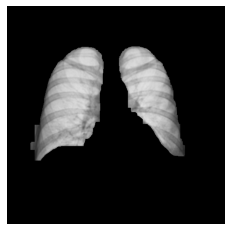

In [13]:
#for im in cov:
im = covm[3]
ShowImage(im)
prediction = model(np.array([im]))
if prediction[0] >= 0.5:
  prediction_class = 1
else:
  prediction_class = 0  
call_model_args = {class_idx_str: prediction_class}
print("Prediction class: " + str(prediction_class))

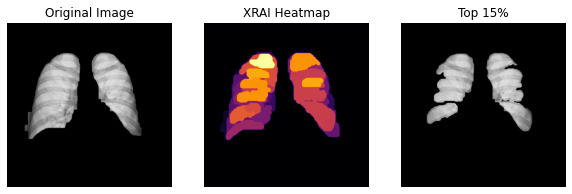

In [14]:
with tf.device('/device:GPU:0'):
    # Construct the saliency object. This alone doesn't do anthing.
  xrai_object = saliency.XRAI()

  # Compute XRAI attributions with default parameters
  xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=4)

  # Set up matplot lib figures.
  ROWS = 1
  COLS = 3
  UPSCALE_FACTOR = 20
  P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

  # Show original image
  ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

  # Show XRAI heatmap attributions
  ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

  # Show most salient x% of the image
  mask = xrai_attributions > np.percentile(xrai_attributions, 85)
  im_mask = np.array(im)
  im_mask[~mask] = 0
  ShowImage(im_mask, title='Top 15%', ax=P.subplot(ROWS, COLS, 3))